In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

cmap = "RdBu_r"

In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH = pickle.load(handle)

with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH = pickle.load(handle)   

In [3]:
PVH_mouse_to_be_analyzed = "HL210"
VMH_mouse_to_be_analyzed = "HL303" 

In [12]:
def get_snips(data, mouse):

    snips_full = []

    kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

    pre = 5
    post = 10
    mineventlength=8
    binlength=0.1

    for key, val in data.items():
        if val["mouse_ID"]==mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata= tp.lickCalc(val["licks"], minrunlength=3)

            snipper = tp.Snipper(val["corrected"],
                                    lickdata["rStart"],
                                    end=lickdata["rEnd"],
                                    fs=val["fs"],
                                    pre=pre,
                                    post=post,
                                    binlength=binlength,
                                    zscore=True
                                    )

            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
            snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            snips_full.append(snipper.snips)

    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")
    
    return snips_full

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

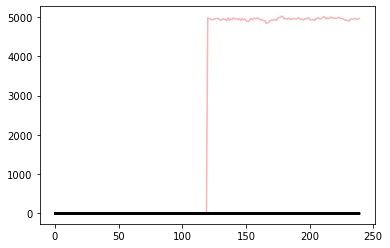

In [13]:
PVH_snips_full = get_snips(PVH, PVH_mouse_to_be_analyzed)
VMH_snips_full = get_snips(VMH, VMH_mouse_to_be_analyzed)

In [14]:
print("number of runs for representative PVH mouse:", len(PVH_snips_full))
print("number of runs for representative VMH mouse:", len(VMH_snips_full))

number of runs for representative PVH mouse: 39
number of runs for representative VMH mouse: 31


In [15]:
pre = 5
post = 10
mineventlength=8
binlength=0.1

eventbalance=[6,2]

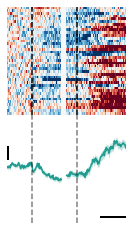

In [16]:
#PVH mouse
f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2,
                                           figsize=[2,3],
                                           gridspec_kw={
                                                    "width_ratios":[10,1],
                                                    "hspace": 0,
                                                    "left": 0,
                                                    "top": 1,
                                                    "bottom": 0,
                                                    "right": 1
                                                        }
)

sns.heatmap(PVH_snips_full, ax=ax1, cbar_ax= ax2, cmap=cmap, vmax=3, vmin=-3,
            cbar_kws={"ticks": []})    

try:
    assert(eventbalance[0] + eventbalance[1] == mineventlength)
    early_t = eventbalance[0]
    late_t = eventbalance[1]
except:
    print("No event balance given. Using default 50-50 split.")
    early_t = mineventlength/2
    late_t = mineventlength/2
            
bins_early = int((pre + early_t) / binlength)
bins_late = int((post + late_t) / binlength)


x1 = np.arange(0,bins_early)
x2 = np.arange(PVH_snips_full.shape[1] - bins_late, PVH_snips_full.shape[1])

mean = np.mean(PVH_snips_full, axis=0)
error_values = np.std(PVH_snips_full, axis=0) / np.sqrt(len(PVH_snips_full))

color=colors_PVH

ax3.plot(x1, mean[:bins_early], color=color)
ax3.plot(x2, mean[-bins_late:], color=color)
ax3.fill_between(x1, mean[:bins_early]-error_values[:bins_early], mean[:bins_early]+error_values[:bins_early], color=color, alpha=0.3, linewidth=0)
ax3.fill_between(x2, mean[-bins_late:]-error_values[-bins_late:], mean[-bins_late:]+error_values[-bins_late:], color=color, alpha=0.3, linewidth=0)

ax2.remove()
ax4.remove()

ax1.set_yticks([])
ax1.set_xticks([])
ax1.axvline(50, color="black", linestyle="--")
ax1.axvline(140, color="black", linestyle="--")

ax3.set_yticks([])
ax3.set_xticks([])

ax3.set_xlim([0,240])
ax3.set_ylim([-4.5, 4])

for spine in ["top", "right", "left", "bottom"]:
    ax3.spines[spine].set_visible(False)

transform = blended_transform_factory(ax3.transData, ax3.transAxes)
ax3.plot([190,240], [0.05, 0.05], linewidth=2, color="k", transform=transform)

ax3.plot([2,2], [0.5, 1.5], linewidth=2, color="k")

ax3.axvline(50, color="k", linestyle="--", alpha=0.5)
ax3.axvline(140, color="k", linestyle="--", alpha=0.5)

f.savefig(FIGSFOLDER / "PVH_rep_snips.pdf")

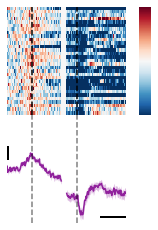

In [14]:
#VMH mouse
f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2,
                                           figsize=[2,3],
                                           gridspec_kw={
                                                    "width_ratios":[10,1],
                                                    "hspace": 0,
                                                    "left": 0,
                                                    "top": 1,
                                                    "bottom": 0,
                                                    "right": 1
                                                        }
                                           )

sns.heatmap(VMH_snips_full, ax=ax1, cbar_ax= ax2, cmap=cmap, vmax=3, vmin=-3,
            cbar_kws={"ticks": []})    

try:
    assert(eventbalance[0] + eventbalance[1] == mineventlength)
    early_t = eventbalance[0]
    late_t = eventbalance[1]
except:
    print("No event balance given. Using default 50-50 split.")
    early_t = mineventlength/2
    late_t = mineventlength/2
            
bins_early = int((pre + early_t) / binlength)
bins_late = int((post + late_t) / binlength)

x1 = np.arange(0,bins_early)
x2 = np.arange(VMH_snips_full.shape[1] - bins_late, VMH_snips_full.shape[1])

mean = np.mean(VMH_snips_full, axis=0)
error_values = np.std(VMH_snips_full, axis=0) / np.sqrt(len(VMH_snips_full))

color=colors_VMH

ax3.plot(x1, mean[:bins_early], color=color)
ax3.plot(x2, mean[-bins_late:], color=color)
ax3.fill_between(x1, mean[:bins_early]-error_values[:bins_early], mean[:bins_early]+error_values[:bins_early], color=color, alpha=0.3, linewidth=0)
ax3.fill_between(x2, mean[-bins_late:]-error_values[-bins_late:], mean[-bins_late:]+error_values[-bins_late:], color=color, alpha=0.3, linewidth=0)

ax4.remove()

ax1.set_yticks([])
ax1.set_xticks([])
ax1.axvline(50, color="black", linestyle="--")
ax1.axvline(140, color="black", linestyle="--")

ax3.set_yticks([])
ax3.set_xticks([])

ax3.set_xlim([0,240])
ax3.set_ylim([-4.5, 4])

for spine in ["top", "right", "left", "bottom"]:
    ax3.spines[spine].set_visible(False)

transform = blended_transform_factory(ax3.transData, ax3.transAxes)
ax3.plot([190,240], [0.05, 0.05], linewidth=2, color="k", transform=transform)

ax3.plot([2,2], [0.5, 1.5], linewidth=2, color="k")

ax3.axvline(50, color="k", linestyle="--", alpha=0.5)
ax3.axvline(140, color="k", linestyle="--", alpha=0.5)

f.savefig(FIGSFOLDER / "VMH_rep_snips.pdf")